In [7]:
!pip install open3d


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


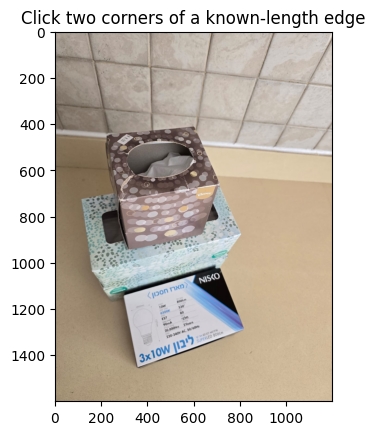

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# === Step 0: Load Grayscale Images ===
img1 = cv2.imread('box1-1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('box1-2.jpg', cv2.IMREAD_GRAYSCALE)
color_img1 = cv2.imread('box1-1.jpg')  # for UI


# === Step 1: Detect and Compute SIFT Keypoints ===
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# === Step 2: Match Features with Ratio Test ===
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

# === Step 3: Define Camera Intrinsics (approximate) ===
focal_length = 1000  # pixels
cx, cy = img1.shape[1] // 2, img1.shape[0] // 2

K = np.array([[focal_length, 0, cx],
              [0, focal_length, cy],
              [0, 0, 1]])

# === Step 4: Compute Essential Matrix ===
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=1.0)

# === Step 5: Recover Pose (R, t) ===
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

# === Step 6: Build Projection Matrices ===
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))

# === Step 7: Undistort Points and Triangulate ===
pts1_norm = cv2.undistortPoints(np.expand_dims(pts1, axis=1), K, None)
pts2_norm = cv2.undistortPoints(np.expand_dims(pts2, axis=1), K, None)

points_4d = cv2.triangulatePoints(P1, P2, pts1_norm, pts2_norm)
points_3d = points_4d[:3] / points_4d[3]  # Convert from homogeneous


# === Interactive Clicks in Colab ===
clicked_pts = []

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        clicked_pts.append((x, y))
        print(f"Clicked at: ({x}, {y})")

        plt.plot(x, y, 'ro')
        if len(clicked_pts) == 2:
            plt.plot([clicked_pts[0][0], clicked_pts[1][0]],
                     [clicked_pts[0][1], clicked_pts[1][1]], 'b-')
            plt.title("2 Points Selected")
        plt.draw()

        if len(clicked_pts) == 2:
            fig.canvas.mpl_disconnect(cid)

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(color_img1, cv2.COLOR_BGR2RGB))
plt.title("Click two corners of a known-length edge")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()



In [26]:
# === Match Clicked Points to Keypoints ===
indices = []
for (x, y) in clicked_pts:
    dists = [np.linalg.norm((x - kp[0]) + (y - kp[1])) for kp in pts1]
    idx = np.argmin(dists)
    indices.append(idx)

i, j = indices
print(f"Closest keypoint indices: {i}, {j}")

# === Scale Point Cloud ===
real_distance_cm = 12.5  # CHANGE THIS to your known box edge in cm
dist_3d = np.linalg.norm(points_3d[:, i] - points_3d[:, j])
scale = real_distance_cm / dist_3d
points_scaled = (points_3d * scale).T  # (N, 3)

# === Step 7: Convert to Open3D Point Cloud ===
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_scaled)

# === Step 8: Estimate Mesh from Point Cloud ===
pcd.estimate_normals()

# === Step 1: Cluster the point cloud (DBSCAN) ===
labels = np.array(pcd.cluster_dbscan(eps=2.5, min_points=30))
num_clusters = labels.max() + 1
print(f"🔍 Found {num_clusters} box clusters.")

total_volume = 0.0

# === Step 2: Loop through clusters and compute box volumes ===
for cluster_id in range(num_clusters):
    cluster_mask = labels == cluster_id
    cluster_points = np.asarray(pcd.points)[cluster_mask]

    if len(cluster_points) < 10:
        continue  # skip small noise

    cluster_pcd = o3d.geometry.PointCloud()
    cluster_pcd.points = o3d.utility.Vector3dVector(cluster_points)

    bbox = cluster_pcd.get_axis_aligned_bounding_box()
    extent = bbox.get_extent()  # [x, y, z]
    volume = extent[0] * extent[1] * extent[2]
    total_volume += volume

    print(f"📦 Box {cluster_id}: {extent} cm → Volume ≈ {volume:.2f} cm³")

print(f"\n✅ Total Estimated Structure Volume: {total_volume:.2f} cm³")

# Optional: visualize each box in different color
pcd.colors = o3d.utility.Vector3dVector(plt.cm.tab10(labels / num_clusters)[:, :3])
# o3d.visualization.draw_geometries([pcd])
# mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)

# # Optional: Remove low-density areas (noise)
# bbox = pcd.get_axis_aligned_bounding_box()
# mesh_crop = mesh.crop(bbox)

# # === Step 9: Estimate Volume ===
# volume = mesh_crop.get_volume()
# print(f"Estimated Volume: {volume:.2f} cm³")

# # === Step 10: Visualize ===
# o3d.visualization.draw_geometries([mesh_crop])


ValueError: not enough values to unpack (expected 2, got 0)

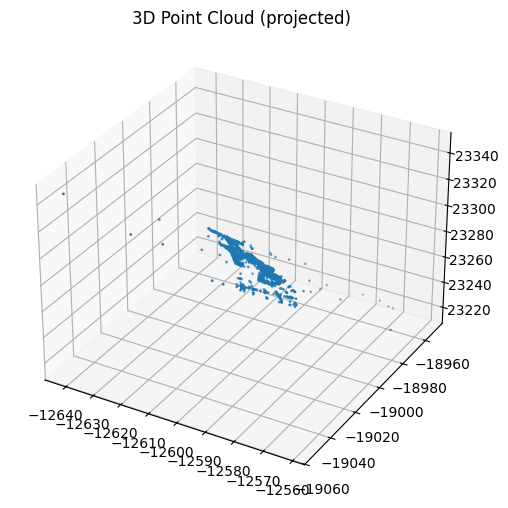

In [11]:
import matplotlib.pyplot as plt

xyz = np.asarray(pcd.points)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], s=1)
plt.title("3D Point Cloud (projected)")
plt.show()
